## Using Variational Autoencoder for Out-Of-Distribution data detection
### A variational autoencoder for input regeration is designed which takes embedded vector as input, performs compression and regerates it as the output

In [2]:
#Importing all required libraries
from keras.layers import Layer, Bidirectional, Dense,Flatten, Embedding, Input, Lambda, LSTM, RepeatVector, TimeDistributed, Layer, Activation, Dropout
from keras.preprocessing.sequence import pad_sequences
from keras.layers.advanced_activations import ELU
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CosineSimilarity
from tensorflow.keras.losses import mse
from tensorflow.keras.losses import Reduction
from tensorflow.keras import optimizers
#from keras import backend as K
from tensorflow.keras import backend as K
from keras.models import Model
from keras.layers import Reshape
from scipy import spatial
import nltk
from nltk.corpus import stopwords
import tensorflow as tf
import pandas as pd
import numpy as np
import codecs
import re
import string
import math
import csv
import os
import keras

import matplotlib.pyplot as plt
%matplotlib inline

#### The input dataset downloaded from kaggle. This dataset contains 15000 user's spoken queries collected over 150 intent classes, it also contains 1000 out-of-domain (OOD) sentences that are not covered by any of the known classes.

OOS - Out-of-scope data

In [3]:
# Reading input jason files into pandas dataframe
df_train = pd.read_json('is_train.json')
df_val = pd.read_json('is_val.json')
df_test = pd.read_json('is_test.json')

oos_train = pd.read_json('oos_train.json')
oos_val = pd.read_json('oos_val.json')
oos_test = pd.read_json('oos_test.json')

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       15000 non-null  object
 1   1       15000 non-null  object
dtypes: object(2)
memory usage: 234.5+ KB


In [5]:
df_train.columns = ['question','intent']
df_val.columns = ['question','intent']
df_test.columns = ['question','intent']

oos_train.columns = ['question','intent']
oos_val.columns = ['question','intent']
oos_test.columns = ['question','intent']

### Data preprocessing :
Stop words and punctuatons are removed from all input samples.

In [6]:
nltk.download('stopwords')



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tejashri/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
stop_words = stopwords.words('english')

print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [10]:
# Removing stop words
df_train['question'] = df_train['question'].apply(lambda x : remove_stopwords(x))
df_test['question'] = df_test['question'].apply(lambda x : remove_stopwords(x))
df_val['question'] = df_val['question'].apply(lambda x : remove_stopwords(x))

oos_train['question'] = oos_train['question'].apply(lambda x : remove_stopwords(x))
oos_test['question'] = oos_test['question'].apply(lambda x : remove_stopwords(x))
oos_val['question'] = oos_val['question'].apply(lambda x : remove_stopwords(x))

In [11]:
# Removing punctuations
df_train['question'] = df_train['question'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '' , x))
df_test['question'] = df_test['question'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '' , x))
df_val['question'] = df_val['question'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '' , x))

oos_train['question'] = oos_train['question'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '' , x))
oos_test['question'] = oos_test['question'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '' , x))
oos_val['question'] = oos_val['question'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '' , x))

In [12]:
in_queries = df_train.question
oos_queries = oos_train.question

### Input text is tokenized using keras preprocessing library and converted into GloVe embedding vectors

In [17]:
#Tokenizing text data

MAX_SEQUENCE_LENGTH = 8
MAX_NB_WORDS = 12000
EMBEDDING_DIM = 50
GLOVE_EMBEDDING = "glove/glove.6B.50d.txt"

tokenizer = Tokenizer(MAX_NB_WORDS)
tokenizer.fit_on_texts(in_queries)
word_index = tokenizer.word_index #the dict values start from 1 so this is fine with zeropadding
index2word = {v: k for k, v in word_index.items()}
print('Found %s unique tokens' % len(word_index))
sequences = tokenizer.texts_to_sequences(in_queries)
#print(sequences)
data_1 = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH,padding='post')
#print(data_1)
print('Shape of data tensor:', data_1.shape)
NB_WORDS = (min(tokenizer.num_words, len(word_index)) + 1 ) #+1 for zero padding
print(NB_WORDS)
data_1_val = data_1[801000:807000] #select 6000 sentences as validation data

Found 5144 unique tokens
Shape of data tensor: (15000, 8)
5145


In [18]:
data_train = data_1
data_train.shape

(15000, 8)

In [19]:
#Creating GloVe embedding matrix for input texts

embeddings_index = {}
f = open(GLOVE_EMBEDDING, encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

glove_embedding_matrix = np.zeros((NB_WORDS, EMBEDDING_DIM))
for word, i in word_index.items():
    if i < NB_WORDS:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be the word embedding of 'unk'.
            glove_embedding_matrix[i] = embedding_vector
        else:
            glove_embedding_matrix[i] = embeddings_index.get('unk')
print('Null word embeddings: %d' % np.sum(np.sum(glove_embedding_matrix, axis=1) == 0))

Found 400000 word vectors.
Null word embeddings: 1


Defining batch-size, maximum sentence length, embedding vector size, latent vector dimesion and intermediate output dimension

In [24]:
batch_size = 64
max_len = MAX_SEQUENCE_LENGTH
emb_dim = EMBEDDING_DIM
latent_dim = 4
intermediate_dim = 256



Word embeddings are generated using keras Embedding layer

In [20]:
x_embd = Embedding(NB_WORDS, 50, weights=[glove_embedding_matrix],
                            input_length=max_len, trainable=False)(data_train)
x_embd[1].shape

2022-02-22 00:40:49.267578: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorShape([8, 50])

### A sampling function is defined to sample vector z from latent space distribution using mean and variance.
https://keras.io/examples/generative/vae/

In [21]:
class Sampling(Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

### Encoder and decoder model based on image regeneration VAE model and Text Generation VAE examples
https://github.com/NicGian/text_VAE

https://www.tensorflow.org/tutorials/generative/cvae

In [25]:
# encoder model
inputs = Input(shape=(max_len, 50))
h = LSTM(intermediate_dim, return_sequences=False, recurrent_dropout=0.2)(inputs)
xd = Dropout(0.2)(h)
x1 = tf.keras.layers.Dense(intermediate_dim, name = 'x',activation='linear')(xd)
x = Dropout(0.2)(x1)
z_mean = tf.keras.layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = tf.keras.layers.Dense(latent_dim, name='z_log_var')(x)

# use the reparameterization trick and get the output from the sample() function
z = Sampling()([z_mean, z_log_var])

encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 8, 50)]      0           []                               
                                                                                                  
 lstm_2 (LSTM)                  (None, 256)          314368      ['input_2[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 256)          0           ['lstm_2[0][0]']                 
                                                                                                  
 x (Dense)                      (None, 256)          65792       ['dropout_2[0][0]']              
                                                                                            

In [26]:
# decoder model
repeated_context = RepeatVector(max_len)
latent_inputs = Input(shape=(latent_dim), name='z_sampling')
decoder_mean = TimeDistributed(Dense(50, activation='linear'))
decoder_h = LSTM(intermediate_dim, return_sequences=True, recurrent_dropout=0.2)
h_decoded = decoder_h(repeated_context(latent_inputs))
x_decoded_mean = decoder_mean(h_decoded)
outputs = tf.keras.layers.Dense(50, activation='linear')(x_decoded_mean)

# Instantiate the decoder model:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 4)]               0         
                                                                 
 repeat_vector_1 (RepeatVect  (None, 8, 4)             0         
 or)                                                             
                                                                 
 lstm_3 (LSTM)               (None, 8, 256)            267264    
                                                                 
 time_distributed_1 (TimeDis  (None, 8, 50)            12850     
 tributed)                                                       
                                                                 
 dense_3 (Dense)             (None, 8, 50)             2550      
                                                                 
Total params: 282,664
Trainable params: 282,664
Non-trainab

### Custom train step based on VAE example by F. Chollet to include reconstruction and KL loss.
#### Cosine similarity between input embedding vectors and generated embedding vectors is used to calculate reconstruction loss.

https://keras.io/examples/generative/vae/

In [27]:

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = CosineSimilarity(axis=1)(data, reconstruction) + 1
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_sum(kl_loss)
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


### Adam optimizer is used with loss defined in custom train step

In [31]:
opt = optimizers.Adam(learning_rate=0.001, clipvalue=0.5)
vae_model = VAE(encoder, decoder)
vae_model.compile(optimizer=opt, metrics=['accuracy'])

In [32]:
results = vae_model.fit(x_embd,
                        shuffle=True,
                        epochs=10,
                        batch_size=64
                       )

Epoch 1/10
235/235 [==============================] - 14s 46ms/step - loss: 0.7588 - reconstruction_loss: 0.7336 - kl_loss: 0.0079
Epoch 2/10
235/235 [==============================] - 11s 47ms/step - loss: 0.7355 - reconstruction_loss: 0.7323 - kl_loss: 0.0018
Epoch 3/10
235/235 [==============================] - 12s 49ms/step - loss: 0.7331 - reconstruction_loss: 0.7321 - kl_loss: 2.2586e-04
Epoch 4/10
235/235 [==============================] - 12s 51ms/step - loss: 0.7309 - reconstruction_loss: 0.7318 - kl_loss: 2.5175e-04
Epoch 5/10
235/235 [==============================] - 11s 49ms/step - loss: 0.7305 - reconstruction_loss: 0.7318 - kl_loss: 3.1899e-04
Epoch 6/10
235/235 [==============================] - 11s 49ms/step - loss: 0.7298 - reconstruction_loss: 0.7316 - kl_loss: 1.6824e-04
Epoch 7/10
235/235 [==============================] - 12s 49ms/step - loss: 0.7316 - reconstruction_loss: 0.7315 - kl_loss: 1.4566e-04
Epoch 8/10
235/235 [==============================] - 11s 47ms/

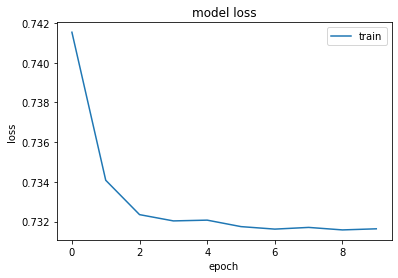

In [33]:
plt.plot(results.history['loss'])
#plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');
plt.show() 

In [35]:
data_test = df_test.question

### Embedding vectors generated for test data 

In [36]:
tokenizer1 = Tokenizer(MAX_NB_WORDS)
tokenizer1.fit_on_texts(data_test)
word_index1 = tokenizer1.word_index #the dict values start from 1 so this is fine with zeropadding
index2word1 = {v: k for k, v in word_index1.items()}
print('Found %s unique tokens' % len(word_index1))
sequences1 = tokenizer1.texts_to_sequences(data_test)
data_2 = pad_sequences(sequences1, maxlen=MAX_SEQUENCE_LENGTH,padding='post')
print('Shape of data tensor:', data_2.shape)
NB_WORDS1 = (min(tokenizer1.num_words, len(word_index1)) + 1 ) #+1 for zero padding
print(NB_WORDS1)

Found 2672 unique tokens
Shape of data tensor: (4500, 8)
2673


In [37]:
print(data_test[0])
print(data_test[249])

would say fly italian
put pto request september 1st september 8th


In [38]:
embeddings_index1 = {}
f = open(GLOVE_EMBEDDING, encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index1[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index1))

glove_embedding_matrix1 = np.zeros((NB_WORDS1, 50))
print(glove_embedding_matrix1.shape)
for word, i in word_index1.items():
    if i < NB_WORDS1:
        embedding_vector = embeddings_index1.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be the word embedding of 'unk'.
            glove_embedding_matrix1[i] = embedding_vector
        else:
            glove_embedding_matrix1[i] = embeddings_index1.get('unk')
print('Null word embeddings: %d' % np.sum(np.sum(glove_embedding_matrix1, axis=1) == 0))

Found 400000 word vectors.
(2673, 50)
Null word embeddings: 1


In [39]:
x_test = Embedding(NB_WORDS1, 50, weights=[glove_embedding_matrix1],
                            input_length=max_len, trainable=False)(data_2)
x_test.shape

TensorShape([4500, 8, 50])

In [40]:
_,_,pred_e = vae_model.encoder.predict(x_test)
pred = vae_model.decoder.predict(pred_e)

In [41]:
print(pred.shape)

(4500, 8, 50)


In [42]:
def get_error_term(v1, v2, _rmse=True):
    if _rmse:
        return np.sqrt(np.mean((v1 - v2) ** 2, axis=1))
    else:
        return CosineSimilarity(v1, v2)

In [46]:
mae_vector = get_error_term(pred, x_test, _rmse=True)
print(f'Average error: {np.mean(mae_vector)}')
cs = (CosineSimilarity(axis=1)(x_embd[1:2], x_embd[1:2]))+ 1
print(f'Cosine similarity loss when input and output are same : {cs}')
pred_cs = (CosineSimilarity(axis=1)(x_embd[1:2], x_test[1:2]))+ 1 
print(f'Cosine similarity loss with output vector : {pred_cs}')


Average error: 0.5576151609420776
Cosine similarity loss when input and output are same : 0.0
Cosine similarity loss with output vector : 0.8894054889678955
